## Requirements

Please install cuda on your device if you have a GPU available.  
This line in the miniconda prompt worked for me: conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0  
You can refer to this: https://stackoverflow.com/questions/45662253/can-i-run-keras-model-on-gpu  
And also this: https://www.tensorflow.org/install/pip#linux

## Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Makes visible cuda devices, -1 otherwise

In [2]:
from helpers import *
from models import *

import numpy as np
import cv2

import math
import random


import skimage.io as io
import skimage.transform as trans

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
print(f'This value has to be at most 2.10.x ---> {tf.__version__}')

This value has to be at most 2.10.x ---> 2.13.1


In [3]:
# This will print logs and cannot be disabled (except restart). Run only to check that GPU is enabled
#tf.debugging.set_log_device_placement(True)

In [4]:
# Make use of GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# with tf.device('/cpu:0'): Force CPU utilization instead of GPU
# This code should run on the GPU, you can see it by uncommenting the code in the previous cell
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Num GPUs Available:  0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


## Constants

In [5]:
%run models.py # If you have error of XXX not found below, try this
%run helpers.py

In [6]:
TRAIN_DIRECTORY_PATH = 'training/'
TRAIN_IMAGES_PATH = TRAIN_DIRECTORY_PATH + 'images/'
TRAIN_GROUNDTRUTH_PATH = TRAIN_DIRECTORY_PATH + 'groundtruth/'

PATCH_SIZE = 96
NUMBER_NEW_TRAINING_TO_TAKE = 0 # Used
NUMBER_CHANNELS_INPUT = 3
BATCH_SIZE = 64 # Put 16 to avoid burning your laptop

MODEL_FUNCTION = fat_unet # Just implement your model in models.py and change this
MODEL = MODEL_FUNCTION((PATCH_SIZE, PATCH_SIZE, NUMBER_CHANNELS_INPUT), verbose = False)

CHECKPOINT_PATH = "check_points/" + str(MODEL_FUNCTION.__name__)
SAVE_MODEL_PATH = "models/" + str(MODEL_FUNCTION.__name__) + ".h5"

RANDOM = np.random.randint(69)

tf.random.set_seed(RANDOM)

In [7]:
# Load model from local models folder
#MODEL = tf.keras.models.load_model(SAVE_MODEL_PATH, custom_objects={'get_f1': get_f1})

## Load data

### Train

In [27]:
train_images = []

for file in tqdm(os.listdir(TRAIN_IMAGES_PATH), total=len(os.listdir(TRAIN_IMAGES_PATH))):
    
    if os.path.isdir(file):
        continue
    
    img = plt.imread(TRAIN_IMAGES_PATH + file)
    img_split = split_into_patches(img, PATCH_SIZE)
    train_images.append(img_split)


train_images = np.array(train_images)

# Below, this merges the first two dimensions. Instead of having x elements of y patches, we have x*y patches.
train_images = combine_dims(train_images, start = 0, count = 2)
print(f'Base train shape: {train_images.shape}')


 22%|█████████████████▏                                                             | 469/2160 [03:20<12:03,  2.34it/s]


MemoryError: Unable to allocate 101. MiB for an array with shape (2160, 4096, 3) and data type float32

In [58]:
train_labels = []

for file in tqdm(os.listdir(TRAIN_GROUNDTRUTH_PATH),total=len(os.listdir(TRAIN_GROUNDTRUTH_PATH))):
    
    if os.path.isdir(file):
        continue
    
    img = plt.imread(TRAIN_GROUNDTRUTH_PATH + file)
    img_split = split_into_patches(img, PATCH_SIZE)
    train_labels.append(img_split)


    
train_labels = np.array(train_labels)

train_labels = combine_dims(train_labels, start = 0, count = 2)
# Below, this adds a dimension at the end, such that the image is of size x*x*1, where 1 is the grayscale value of the pixel
train_labels = train_labels[:, :, :, np.newaxis]

print(train_labels.shape)


  3%|██▍                                                                             | 66/2160 [00:03<02:04, 16.88it/s]


KeyboardInterrupt: 

### Test

In [91]:
test_images = []
test_ids = []

for directory in ['../UAV-benchmark-M/M0101/']:
    for file in os.listdir(directory):
        if file.endswith('img000001.jpg'):
            test_ids.append(file)
            img = plt.imread(directory + file)
            img = cv2.resize(img, [1024, 540])
            if img.shape[-1] == 4:
                img = img[:,:,:3]
            img_split = split_into_patches(img, PATCH_SIZE)
            test_images.append(img_split)
        

test_images = np.array(test_images)
# Below, this merges the first two dimensions. Instead of having x elements of y patches, we have x*y patches.
test_images = combine_dims(test_images, start = 0, count = 2)
print(test_images.shape)

test_ids = [x.split(".")[0] for x in test_ids]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.86it/s]


(2450, 96, 96, 3)


### Split for validation

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size = 0.20, random_state = RANDOM)
print(X_train.shape)

(2000, 96, 96, 3)


## Call model

In [12]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH, save_weights_only=True, verbose=1, save_best_only=True)]

In [13]:
# BEST_MODEL_PATH = "models_best/" + str(MODEL_FUNCTION.__name__) + ".h5" # Without preprocessing groundtruth

# MODEL = tf.keras.models.load_model(BEST_MODEL_PATH, custom_objects={'get_f1': get_f1}) # Once you run the model once, you can train more by running this cell again
train_gen = DataGenerator(X_train, y_train, BATCH_SIZE)
test_gen = DataGenerator(X_test, y_test, BATCH_SIZE)

MODEL.fit(train_gen, verbose=True, epochs=25, validation_data=test_gen, shuffle=True, callbacks=callbacks)
MODEL.save(SAVE_MODEL_PATH)

Epoch 1/25
32/32 [==============================] - ETA: 0s - loss: 0.4634 - get_f1: 1.2784e-05 
Epoch 1: val_loss improved from inf to 0.38036, saving model to check_points\fat_unet
32/32 [==============================] - 508s 16s/step - loss: 0.4634 - get_f1: 1.2784e-05 - val_loss: 0.3804 - val_get_f1: 0.0000e+00
Epoch 2/25
32/32 [==============================] - ETA: 0s - loss: 0.3393 - get_f1: 0.0000e+00 
Epoch 2: val_loss improved from 0.38036 to 0.32795, saving model to check_points\fat_unet
32/32 [==============================] - 503s 16s/step - loss: 0.3393 - get_f1: 0.0000e+00 - val_loss: 0.3280 - val_get_f1: 0.0000e+00
Epoch 3/25
32/32 [==============================] - ETA: 0s - loss: 0.3217 - get_f1: 0.0000e+00 
Epoch 3: val_loss improved from 0.32795 to 0.32344, saving model to check_points\fat_unet
32/32 [==============================] - 503s 16s/step - loss: 0.3217 - get_f1: 0.0000e+00 - val_loss: 0.3234 - val_get_f1: 0.0000e+00
Epoch 4/25
32/32 [====================

C:\Users\thami\anaconda3\envs\introml\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
MODEL.save(SAVE_MODEL_PATH)

C:\Users\thami\anaconda3\envs\introml\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Instead of running the model you can fetch it from the file

In [9]:
MODEL.load_weights("check_points_best/" + str(MODEL_FUNCTION.__name__))
MODEL.load_weights(CHECKPOINT_PATH) #Loads best model
#print(MODEL.weights)

In [69]:
BEST_MODEL_PATH = "models_best/" + str(MODEL_FUNCTION.__name__) + ".h5" # Without preprocessing groundtruth

MODEL = tf.keras.models.load_model(BEST_MODEL_PATH, custom_objects={'get_f1': get_f1}) # Once you run the model once, you can train more by running this cell again


### Sanity checks

1/1 [==============================] - 0s 258ms/step


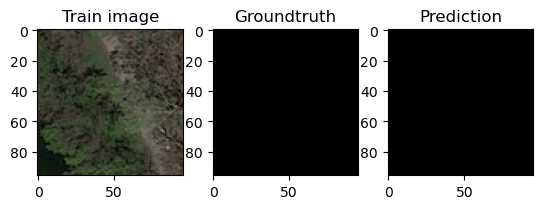

In [14]:
patch_you_want_to_see = 1
pred_threshold = 0.2

fig, ax = plt.subplots(1,3)

ax[0].imshow(X_train[patch_you_want_to_see])
ax[0].title.set_text('Train image')
ax[1].imshow(y_train[patch_you_want_to_see], cmap="gray")
ax[1].title.set_text('Groundtruth')

prediction = MODEL.predict(X_train[patch_you_want_to_see][np.newaxis, :, :, :]) # Need to add an axis in front as mode expects batch
prediction = (prediction > pred_threshold).astype(np.uint8) # Transforms continuous values into 0-1

ax[2].imshow(prediction[0], cmap="gray")
ax[2].title.set_text('Prediction')

### Check test images

In [81]:
BEST_MODEL_PATH = "models_best/" + str(MODEL_FUNCTION.__name__) + ".h5" 

MODEL = tf.keras.models.load_model(BEST_MODEL_PATH, custom_objects={'get_f1': get_f1}) # Once you run the model once, you can train more by running this cell again

models_best/fat_unet.h5


In [94]:
image_you_want_to_see = 0
patch_side_len = 7 # DEPENDS ON SIZE OF IMAGE AND PATCHSIZE
pred_threshold = 0.2

test_image_side_len = patch_side_len * PATCH_SIZE
reconstructed_image = np.zeros((test_image_side_len, test_image_side_len, 3))
reconstructed_gt = np.zeros((test_image_side_len, test_image_side_len, 1))

#### SongDo & Galatsi

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:48<00:00,  6.86s/it]


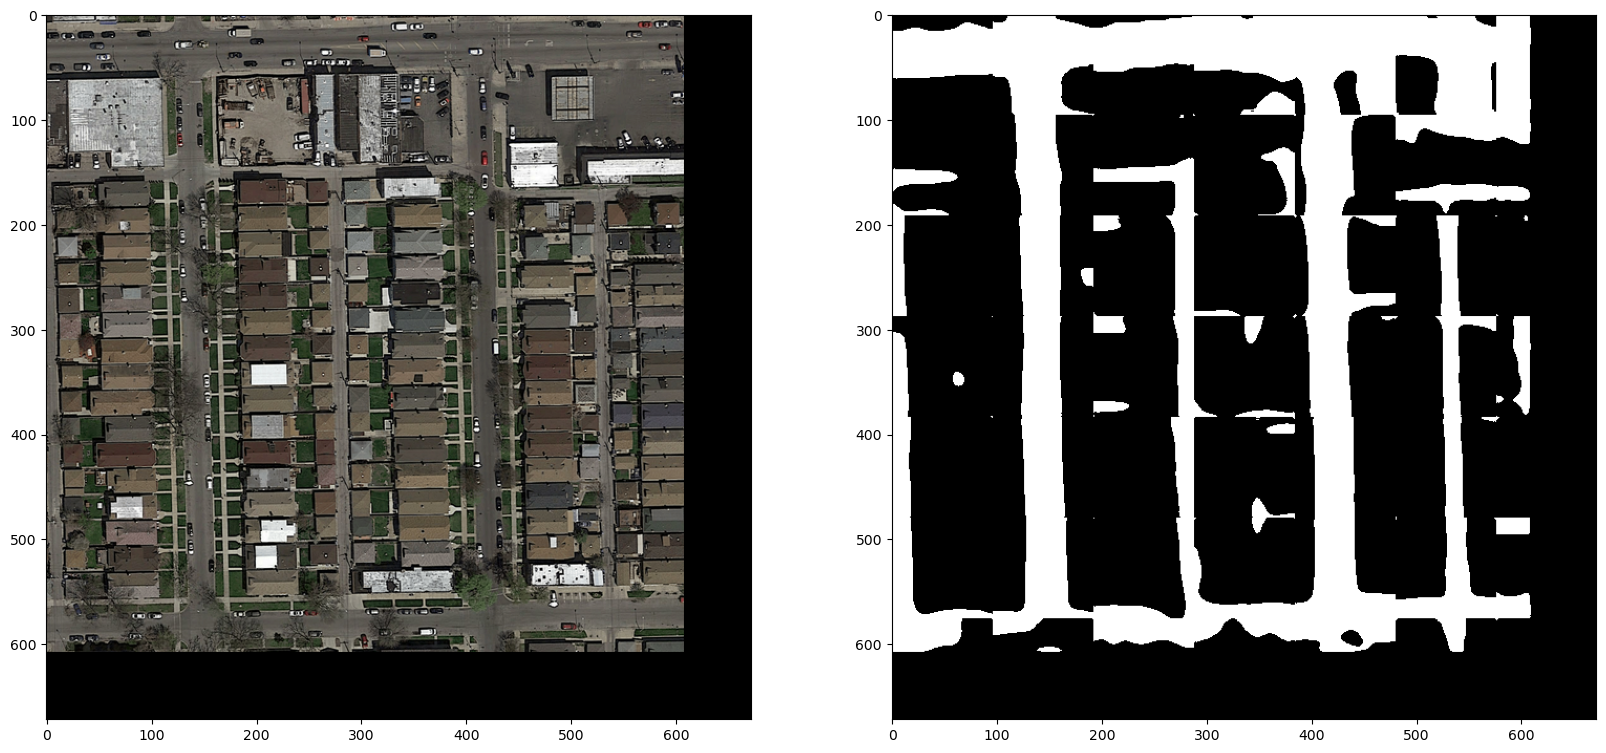

In [95]:
fig, ax = plt.subplots(1,2, figsize=(20,30))
for i in tqdm(range(patch_side_len*image_you_want_to_see,patch_side_len*image_you_want_to_see + patch_side_len)):
    for j in range(patch_side_len):
        reconstructed_image[(i-patch_side_len*image_you_want_to_see)*PATCH_SIZE : (i-patch_side_len*image_you_want_to_see)*PATCH_SIZE + PATCH_SIZE, j*PATCH_SIZE : j*PATCH_SIZE + PATCH_SIZE] = test_images[patch_side_len*i + j]

ax[0].imshow(reconstructed_image)

for i in tqdm(range(patch_side_len*image_you_want_to_see,patch_side_len*image_you_want_to_see + patch_side_len)):
    for j in range(patch_side_len):
        prediction = MODEL.predict(test_images[patch_side_len*i + j][np.newaxis, :, :, :], verbose = False)
        prediction = (prediction > pred_threshold).astype(np.uint8)
        reconstructed_gt[(i-patch_side_len*image_you_want_to_see)*PATCH_SIZE : (i-patch_side_len*image_you_want_to_see)*PATCH_SIZE + PATCH_SIZE, j*PATCH_SIZE : j*PATCH_SIZE + PATCH_SIZE] = prediction[0]

ax[1].imshow(reconstructed_gt, cmap='gray')

#### UAVDT

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:45<00:00,  7.64s/it]


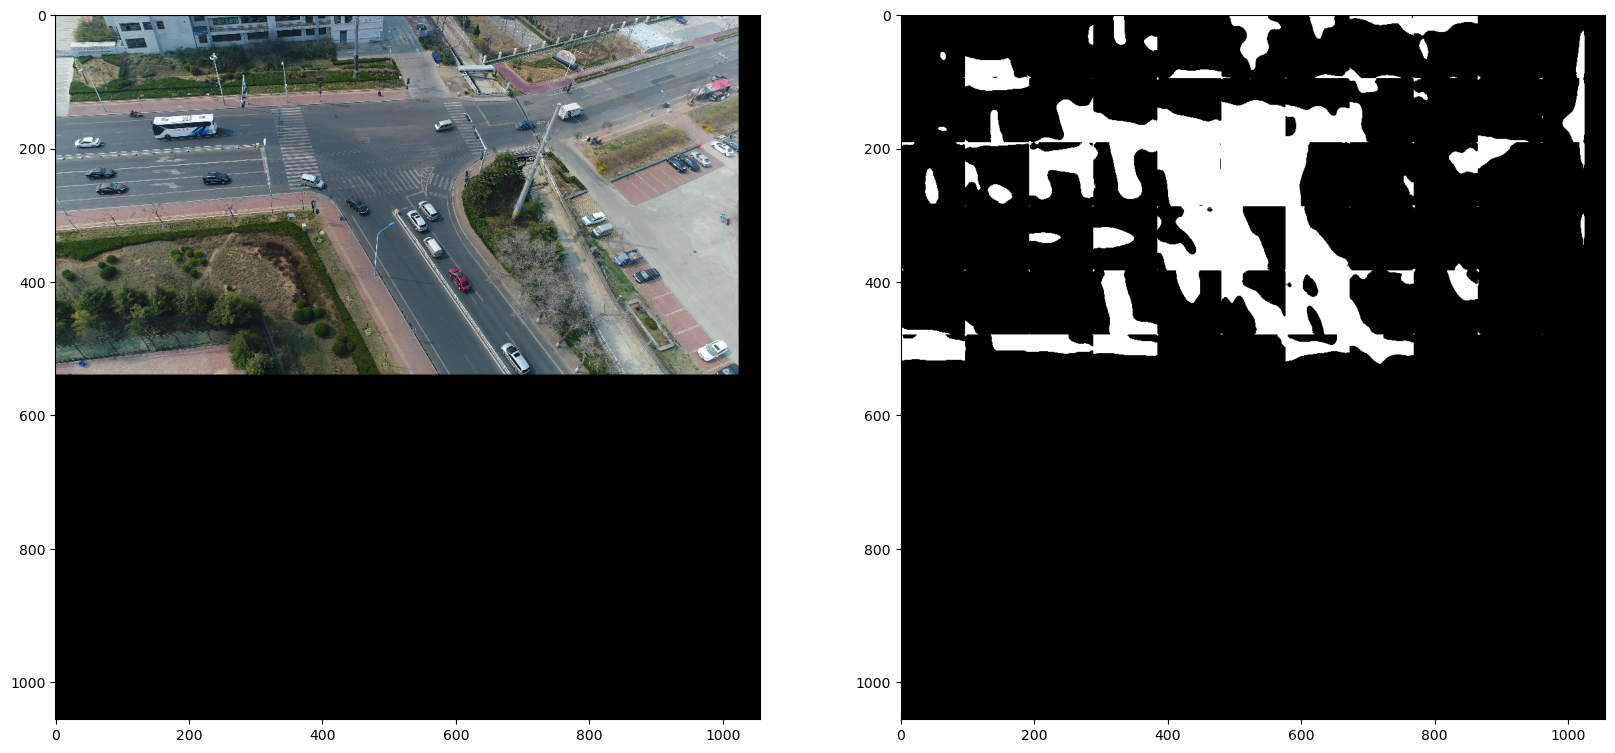

In [90]:
fig, ax = plt.subplots(1,2, figsize=(20,30))
for i in tqdm(range(patch_side_len*image_you_want_to_see,patch_side_len*image_you_want_to_see + patch_side_len - 5)):
    for j in range(patch_side_len):
        reconstructed_image[(i-patch_side_len*image_you_want_to_see)*PATCH_SIZE : (i-patch_side_len*image_you_want_to_see)*PATCH_SIZE + PATCH_SIZE, j*PATCH_SIZE : j*PATCH_SIZE + PATCH_SIZE] = test_images[patch_side_len*i + j]

normalized_image = (reconstructed_image - np.min(reconstructed_image)) / (np.max(reconstructed_image) - np.min(reconstructed_image))      
ax[0].imshow(normalized_image)

for i in tqdm(range(patch_side_len*image_you_want_to_see,patch_side_len*image_you_want_to_see + patch_side_len - 5)):
    for j in range(patch_side_len):
        img_split = test_images[patch_side_len*i + j]
        normalized_patch = (img_split - np.min(img_split)) / (np.max(img_split) - np.min(img_split))
        prediction = MODEL.predict(normalized_patch[np.newaxis, :, :, :], verbose = False)
        prediction = (prediction > pred_threshold).astype(np.uint8)
        reconstructed_gt[(i-patch_side_len*image_you_want_to_see)*PATCH_SIZE : (i-patch_side_len*image_you_want_to_see)*PATCH_SIZE + PATCH_SIZE, j*PATCH_SIZE : j*PATCH_SIZE + PATCH_SIZE] = prediction[0]

ax[1].imshow(reconstructed_gt, cmap='gray')